In [20]:
### packages ###
import random
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib import ticker
import modelbase
from tqdm.notebook import tqdm

from modelbase.ode import Simulator
from scipy.integrate import trapezoid
from typing import Iterable, Dict, Tuple, Optional, Any, List, Union
import itertools as it
from matplotlib import cm
from modelbase.ode import mca

In [21]:
%%capture
cd ..

In [22]:
from models import get_model

In [23]:
%%capture
cd analyses/

In [24]:
y0 = {
    "PQ": 11.027139850905353,
    "PC": 1.8895071932002812,
    "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,
    "NADPH": 0.4882103700673736,
    "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,
    "Psbs": 0.9607146039898598,
    "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,
    "BPGA": 0.0005355311557548053,
    "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,
    "FBP": 0.006126990841013743,
    "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,
    "G1P": 0.041575582577936025,
    "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,
    "E4P": 0.00732079113061801,
    "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,
    "RUBP": 0.13153657267999222,
    "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,
    "ASC": 9.999994138785292,
    "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,
    "GSH": 9.999999991725186,
    "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
}

In [25]:
m = get_model()

In [26]:
#add new parameters with values from Dave Kramer 
m.add_parameter("b6f_content", 1)
m.add_parameter("max_b6f", 500)
m.add_parameter("pKreg", 6.5)

##forward rate constant, consisiting of pH depending component that pumps protons into lumen
##protonation rate, which depends on pH and multiplied with scaling parameter
def k_b6f(pH , pKreg, b6f_content, max_b6f):
    pHmod=(1 - (1 / (10 ** (pH - pKreg) + 1)))
    b6f_deprot=pHmod*b6f_content
    return b6f_deprot * max_b6f

m.add_algebraic_module(module_name="k_b6f",
        function=k_b6f,
        compounds=["pH"],
        derived_compounds=["k_b6f"],
        parameters=["pKreg", "b6f_content", "max_b6f"],)

##because reaction is reversible forward rate constant/eq constant = reverse rate constant
#simple reaction rate, concentration substrates * forwards - concentration products - backwards
##!!!!!!!check whether it is necessary to keep PQ in fraction and not total number!!!!!!!
def vB6f(PC, PCred, PQ, PQred, k_b6f ,Keq_cytb6f):    
    k_b6f_reverse = k_b6f / Keq_cytb6f
    f_PQH2=PQred/(PQred+PQ) #want to keep the rates in terms of fraction of PQHs, not total number
    f_PQ=1-f_PQH2
    return f_PQH2*PC*k_b6f - f_PQ*PCred*k_b6f_reverse 

m.add_reaction(rate_name="vB6f",
        function=vB6f,
        stoichiometry={"PC": -2, "PQ": 1, "H": 4 / m.get_parameter("bH")},
        modifiers=["PQred", "PCred", "k_b6f", "Keq_B6f"],
        dynamic_variables=["PC","PCred", "PQ", "PQred", "k_b6f","Keq_B6f"],
        reversible=True,
    )

In [27]:
m.add_parameter("ATPturnover", 90)


def ATP_gamma(Pi,ATP,ADP,convf):
    return (ATP/convf)/((ADP/convf)*(Pi/1000))

m.add_algebraic_module_from_args(
        module_name="ATP_gamma",
        function=ATP_gamma,
        args=["Pi", "ATP", "ADP", "convf"],
        derived_compounds=["ATP_gamma"])

def deltagATPsyn(pH,gammaATP,DeltaG0_ATP,dG_pH, HPR, pHstroma, RT):
    DG = DeltaG0_ATP - dG_pH * HPR * (pHstroma - pH) + RT* np.log(gammaATP)
    return DG

m.add_algebraic_module_from_args(
    module_name="DeltaGATPsyn",
    function=deltagATPsyn,
    args=["pH","ATP_gamma","DeltaG0_ATP","dG_pH", "HPR", "pHstroma", "RT"],
    derived_compounds=["DeltaGATPsyn"])


m.remove_reaction("vATPsynthase")

def vATPsynthase2(DeltaGATPsyn, ATPturnover):
    return -DeltaGATPsyn*ATPturnover

m.add_reaction(
        rate_name="vATPsynthase",
        function=vATPsynthase2,
        stoichiometry={
            "H": -m.get_parameter("HPR") / m.get_parameter("bH"),
            "ATP": 1 * m.get_parameter("convf"),
        },
        modifiers=["DeltaGATPsyn"],
        dynamic_variables=["DeltaGATPsyn"],
        parameters=["ATPturnover"],
        reversible=True)


In [28]:
def pam_analysis(
    s: Simulator,
    t_relax: float,
    t_pulse: float,
    pfd_dark: float,
    pfd_illumination: float,
    pfd_pulse: float,
    adaption :float,
    time_adaption : float,
    integrator_kwargs: Dict[str, Any] = None,
) -> None:
    if integrator_kwargs is None:
        integrator_kwargs = {}
    s.update_parameter("pfd", adaption)
    s.simulate(time_adaption)
    print("adaption done with:",str(time_adaption)+" and "+str(adaption))
    t = list(it.accumulate(it.chain.from_iterable((t_relax, t_pulse) for i in range(32))))
    for f in range(len(t)):
        t[f]= t[f] + time_adaption
    pfds = list(
        [pfd_dark, pfd_pulse] * 2
        + [pfd_illumination, pfd_pulse] * 10
        + [pfd_dark, pfd_pulse] * 8
    )
    for t_end, pfd in tqdm(zip(t, pfds), total=len(pfds), desc="simulation"):
        s.update_parameter("pfd", pfd)
        s.simulate(t_end, **integrator_kwargs)


def get_light(s: Simulator) -> np.ndarray:
    values = [
        list(it.repeat(par["pfd"], len(t)))
        for par, t in zip(s1.simulation_parameters, s1.get_time(concatenated=False))
    ]
    return np.fromiter(it.chain(*values), dtype="float")


def get_npq(
    s: Simulator,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Calculates the non-photochemical quenching from the extracted
    important points of the PAM simulations

    Returns
    -------
    Fm: Fm (first element of list) and Fm' values
    NPQ: Calculated NPQ values
    tm: Exact time points of peaks in PAM trace
    Fo: Fo (first element of list) and Ft' values
    to: Exact time points of Fo and Ft' values
    """
    # container for lists. Each list contains the positions of fluorescence values for one peak
    z = []

    # container for position of Fo'
    o = []
    cnt = 0

    light = get_light(s1)
    max_light = max(light)
    F = s.get_full_results_df()["Fluo"].values
    t = s.get_time()

    while cnt < len(light):
        if light[cnt] == max_light:
            # temporary container for all F==maxlight. For each peak it is renewed
            h = []
            while cnt != len(light) and light[cnt] == max(light):
                h.append(cnt)
                cnt += 1
            z.append(h)
            o.append(h[0] - 1)  # value directly at the bottom of peak is Fo
        else:
            cnt += 1
    # Fm is the maximal value for each peak sequence
    peaks = [i[np.argmax(F[i])] for i in z]
    Fm = F[peaks]
    tm = t[peaks]
    Fo = F[o]
    to = t[o]
    NPQ = (Fm[0] - Fm) / Fm
    qPSII = (Fm-Fo) / Fm
    return Fm, NPQ, qPSII ,tm, Fo, to

Xantophyll and Psbs total 

In [12]:
Psbs_dict_npq={}
Psbs_dict_tm={}
X_dict_npq={}
X_dict_tm={}

totals=["Psbstot", "Xtot"]
tot_change=[0,0.25,0.5,0.75,1,2]
xo_change=[0.9,1,1.25,1.5,2]
for i in totals:
    if i == "Psbstot":
        for j in tot_change:
            s1=Simulator(m)
            s1.initialise(y0)
            s1.update_parameter("kcyc", 0.0)
            s1.update_parameter("Psbstot",1)
            s1.update_parameter("Xtot",1)
            s1.update_parameter(i,j )
            pam_analysis(
            s1,
            t_relax=120,
            t_pulse=0.8,
            pfd_dark=25,
            pfd_illumination=1000,
            pfd_pulse=5000,
            adaption=25,
            time_adaption=10000
        )
            Fm, NPQ, qPSII, tm, Fo, to = get_npq(s1)
            Psbs_dict_npq[str(j)]= NPQ
            Psbs_dict_tm[str(j)]=tm-10000
    if i == "Xtot":
        for j in xo_change:
            s1=Simulator(m)
            s1.initialise(y0)
            s1.update_parameter("kcyc", 0.0)
            s1.update_parameter(i,j )
            pam_analysis(
            s1,
            t_relax=120,
            t_pulse=0.8,
            pfd_dark=25,
            pfd_illumination=1000,
            pfd_pulse=5000,
            adaption=25,
            time_adaption=10000
        )
            Fm, NPQ, qPSII, tm, Fo, to = get_npq(s1)
            X_dict_npq[str(j)]= NPQ
            X_dict_tm[str(j)]=tm-10000

adaption done with: 10000 and 25


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10000 and 25


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10000 and 25


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10000 and 25


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10000 and 25


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10000 and 25


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10000 and 25


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10000 and 25


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10000 and 25


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10000 and 25


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

adaption done with: 10000 and 25


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

In [14]:
color = cm.rainbow(np.linspace(0, 1, 6))

In [15]:
tm=tm-10000 #get adaption time out of the way

ValueError: x and y must have same first dimension, but have shapes (10,) and (20,)

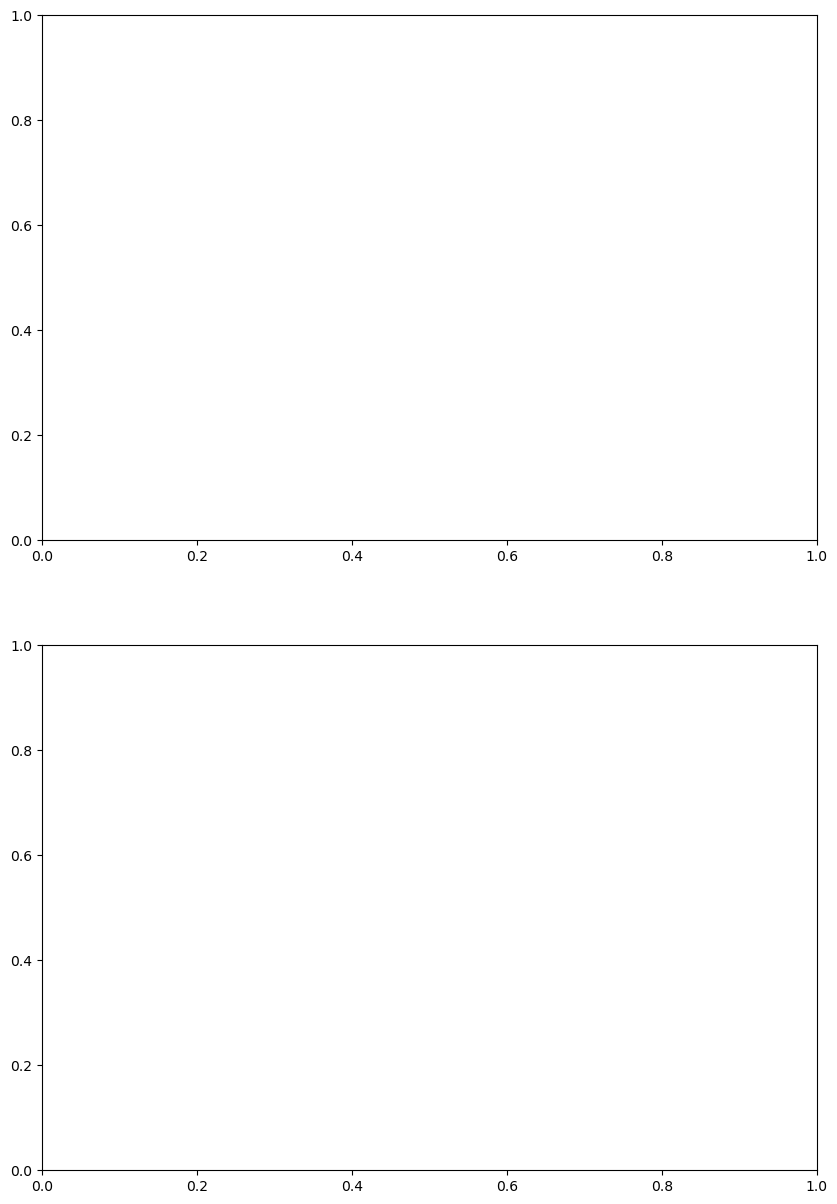

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,15))
for i in range(0,6):
    #ax1.plot(list(Psbs_dict_tm.values())[i],list(Psbs_dict_npq.values())[i], label="total Psbs: "+str(list(Psbs_dict_npq.keys())[i]), color = color[i])
    ax2.plot(list(X_dict_npq.values())[i],list(X_dict_npq.values())[i], label="total Xantophyll: "+str(list(X_dict_npq.keys())[i]),color = color[i])
ax1.legend()
ax2.legend()

NPQ with and without state transitions and with/out adaption

In [31]:
m.get_parameters()

{'convf': 0.032,
 'PSIItot': 2.5,
 'PSItot': 2.5,
 'PQtot': 17.5,
 'PCtot': 4.0,
 'Fdtot': 5.0,
 'Ctot': 2.5,
 'NADPtot': 0.8,
 'APtot': 2.55,
 'Psbstot': 1.0,
 'Xtot': 1.0,
 'kH': 5000000000.0,
 'kH0': 500000000.0,
 'kF': 625000000.0,
 'k1': 5000000000.0,
 'k1rev': 10000000000.0,
 'k2': 5000000000.0,
 'kdeg': 100,
 'krep': 0.000555,
 'kStt7': 0.0035,
 'kPph1': 0.0013,
 'KM_ST': 0.2,
 'n_ST': 2.0,
 'staticAntI': 0.37,
 'staticAntII': 0.1,
 'prob_attach': 1.0,
 'kActATPase': 0.05,
 'kDeactATPase': 0.002,
 'kATPsynth': 20.0,
 'kATPcons': 10.0,
 'ATPcyt': 0.5,
 'Pi_mol': 0.01,
 'DeltaG0_ATP': 30.6,
 'HPR': 4.666666666666667,
 'kNADPHcons': 15.0,
 'NADPHcyt': 0.5,
 'pHstroma': 7.9,
 'kLeak': 10.0,
 'bH': 100.0,
 'kPQred': 250.0,
 'kCytb6f': 2.5,
 'kPTOX': 0.01,
 'kPCox': 2500.0,
 'kFdred': 250000.0,
 'kcatFNR': 500.0,
 'kcyc': 1.0,
 'O2ext': 8.0,
 'kNDH': 0.002,
 'kNh': 0.05,
 'kNr': 0.004,
 'nH': 5.0,
 'EFNR': 3.0,
 'KM_FNR_F': 1.56,
 'KM_FNR_N': 0.22,
 'gamma0': 0.1,
 'gamma1': 0.25,
 'g

In [42]:
s1=Simulator(m)
s1.initialise(y0)
s1.update_parameter("kcyc", 0.0)
s1.update_parameter("Psbstot",1)
s1.update_parameter("Xtot",1)
s1.update_parameter("kStt7",0.000)
s1.update_parameter("kPph1",0.000)
pam_analysis(
            s1,
            t_relax=120,
            t_pulse=0.8,
            pfd_dark=25,
            pfd_illumination=1000,
            pfd_pulse=5000,
            adaption=1,
            time_adaption=10000
        )
Fm, NPQ, qPSII, tm, Fo, to = get_npq(s1)

adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

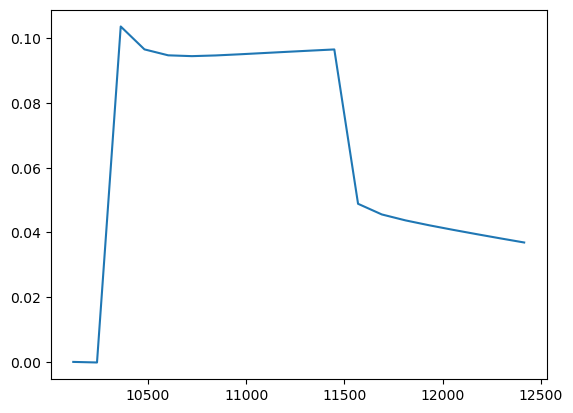

In [43]:
plt.plot(tm,NPQ)